In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import requests
import json

In [30]:
one_person_hh_income = pd.read_csv("one_person_household_income.csv")

In [31]:
one_person_hh_income  = one_person_hh_income[['region', 'mean_annual_income', 'median_annual_income']]

In [32]:
rent = pd.read_csv('rent_api_data.csv')

In [33]:
rent = rent.loc[~rent['area'].isna()]

In [34]:
def clean_rent_data(data, dwell):
    data = data.loc[data['dwell']==dwell]
    data = data.loc[data['nBedrms']=='1']
    data['area'].loc[data['area']=="Manawatu-Wanganui Region"] = "Manawatū–Whanganui Region"
    a = data['med'].loc[data['area'].isin(['Tasman Region', 'Nelson Region', 'Marlborough Region', 'West Coast Region'])].median()
    b = data['med'].loc[data['area'].isin(['Tasman Region', 'Nelson Region', 'Marlborough Region', 'West Coast Region'])].mean()
    c = data['med'].loc[data['area'].isin(['Gisborne Region', "Hawke's Bay Region"])].median()
    d = data['med'].loc[data['area'].isin(['Gisborne Region', "Hawke's Bay Region"])].mean()
    data = data[['area','mean','med']].loc[~data['area'].isin(['Gisborne Region', 
                                                               "Hawke's Bay Region", 
                                                               'Tasman Region', 
                                                               'Nelson Region', 
                                                               'Marlborough Region', 
                                                               'West Coast Region'])]
    dict = {'area': ["Tasman / Nelson / Marlborough / West Coast region", "Gisborne/Hawke's bay region"], 
            'mean': [b, d], 'med': [a, c] }
    avg_reg = pd.DataFrame(dict)
    data = pd.concat([data, avg_reg], ignore_index=True).reset_index()
    data['area'] = data['area'].str.lower()

    return data
    
    

In [35]:
def join_income_and_rent(income, rent):
    rent_income = income.merge(rent, how='left', left_on='region', right_on='area')
    rent_income['annual_mean'] = rent_income['mean']*52.1429
    rent_income['annual_median'] = rent_income['med']*52.1429
    rent_income['affordable_rent_wage_mean'] = rent_income['annual_mean']*3.3333333333333335
    rent_income['affordable_rent_wage_median'] = rent_income['annual_median']*3.3333333333333335
    rent_income['region'] = rent_income['region'].str[:-7]
    rent_income['region_lab'] = ['northland',
              'auckland', 
              'waikato', 
              'bay of\nplenty', 
              "gisborne/\nhawke's bay", 'taranaki', 
              'manawatū\nwhanganui', 'wellington', 'tasman/\nnelson/\nmarlborough/\nwest coast', 'canterbury', 'otago', 'southland']

    return rent_income
    
    

In [36]:
rent_apt = clean_rent_data(rent, dwell='Apartment')
rent_flt = clean_rent_data(rent, dwell='Flat')

/var/folders/9y/26g09rk53q36lrmfkrq7q8q80000gn/T/ipykernel_14580/390453115.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['area'].loc[data['area']=="Manawatu-Wanganui Region"] = "Manawatū–Whanganui Region"
/var/folders/9y/26g09rk53

In [37]:
def combine_flt_apt(rent_apt, rent_flt):
    flt_and_apt = rent_flt.merge(rent_apt, how='left', on='area')
    flt_and_apt['mean'] = (flt_and_apt['mean_x'] + flt_and_apt['mean_y'])/2
    flt_and_apt['med'] = (flt_and_apt['med_x'] + flt_and_apt['med_y'])/2
    flt_and_apt = flt_and_apt[['area', 'mean', 'med']]
    return flt_and_apt
    

In [38]:
rent_flt_and_apt = combine_flt_apt(rent_apt, rent_flt)

In [39]:
onep_flt = join_income_and_rent(one_person_hh_income, rent_flt)

In [40]:
onep_apt = join_income_and_rent(one_person_hh_income, rent_apt)

In [41]:
onep_flt_apt = join_income_and_rent(one_person_hh_income, rent_flt_and_apt)

In [42]:
def plot_rent_income(data, income, income_type, avg, avg_name, dwell_name):
    sns.set_style("whitegrid")
    data.sort_values(by=[avg], ascending=False, inplace=True)
    labels = data['region_lab'].to_list()
    # Create the scatter plot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.scatter(data['region'], data[avg], label=f"Affordable Rent Wage {avg_name}", color='red')
    plt.scatter(data['region'], data[income], label=income, color='grey')
    
    # Add vertical lines
    plt.vlines(data['region'], data[avg], data[income], color='grey', linewidth=1.2, linestyle='dashed')
    
    # Customize the plot
    plt.xlabel("Region")
    plt.ylabel("NZD ($)")
    plt.title(f"{income_type} vs {avg_name} One-bed {dwell_name} Rent")
    plt.grid(True)
    plt.xticks(range(len(data)), labels, rotation=0)
    
    # Add legend with custom labels
    plt.legend(title="Data Series", labels=[f'{avg_name} Affordable One-bed Rent Income', f'{income_type}'])
    
    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()

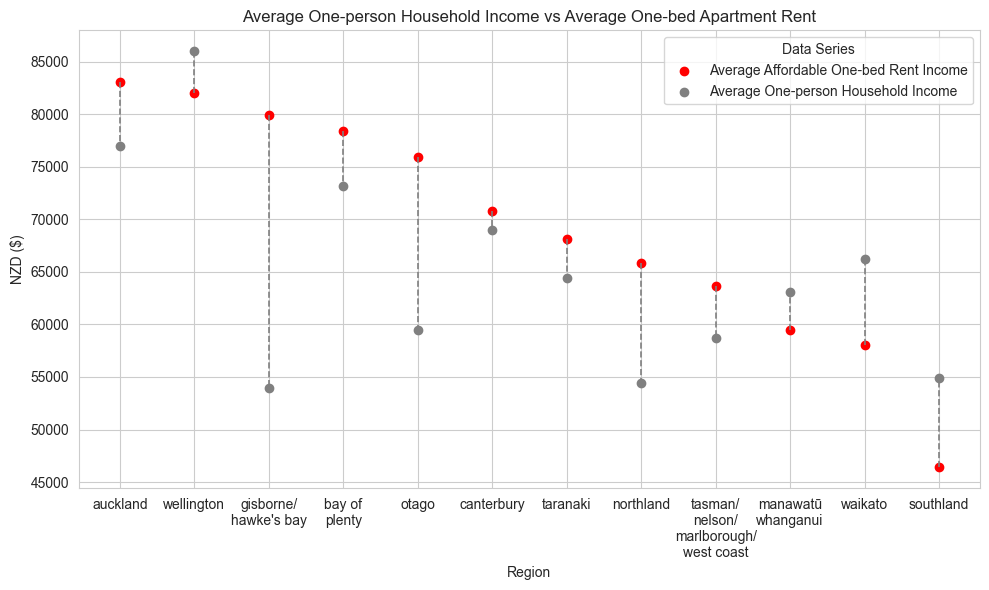

In [43]:
plot_rent_income(onep_apt, 'mean_annual_income', 'Average One-person Household Income', 'affordable_rent_wage_mean', 'Average', 'Apartment')

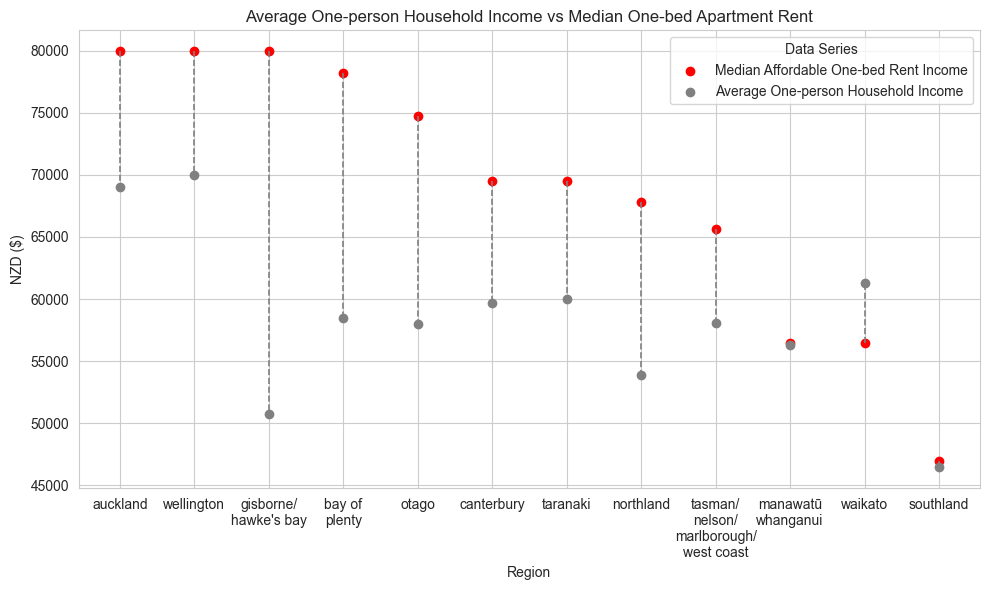

In [44]:
plot_rent_income(onep_apt, 'median_annual_income', 'Average One-person Household Income', 'affordable_rent_wage_median', 'Median', 'Apartment')

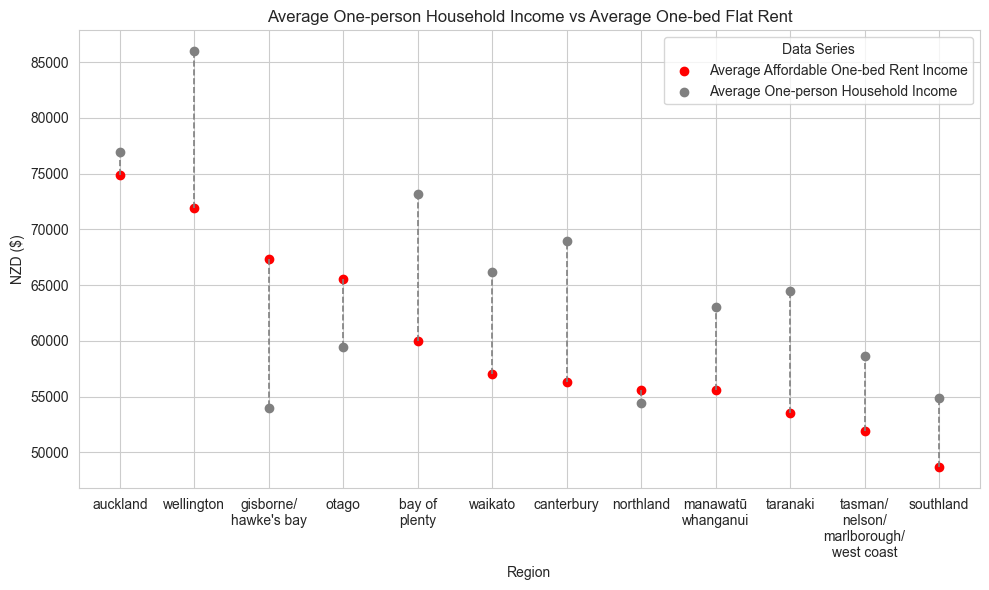

In [45]:
plot_rent_income(onep_flt, 'mean_annual_income', 'Average One-person Household Income', 'affordable_rent_wage_mean', 'Average', 'Flat')

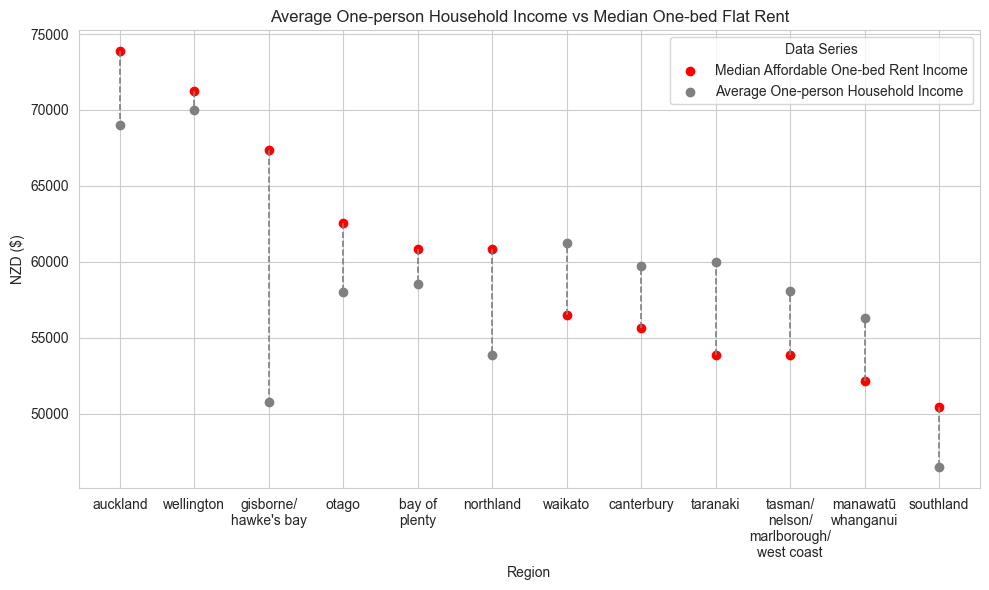

In [46]:
plot_rent_income(onep_flt, 'median_annual_income', 'Average One-person Household Income', 'affordable_rent_wage_median', 'Median', 'Flat')

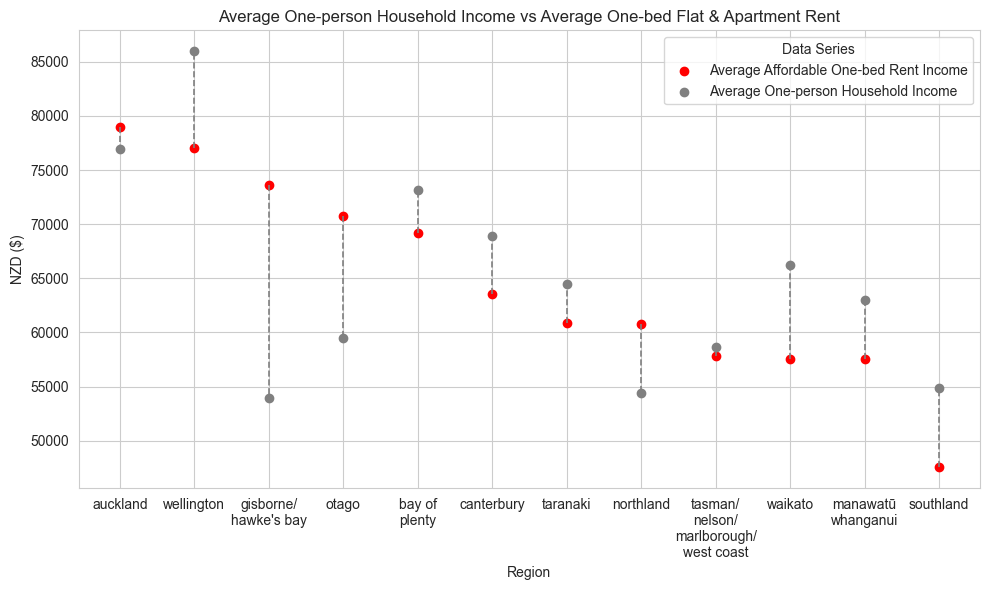

In [47]:
plot_rent_income(onep_flt_apt, 'mean_annual_income', 'Average One-person Household Income', 'affordable_rent_wage_mean', 'Average', 'Flat & Apartment')

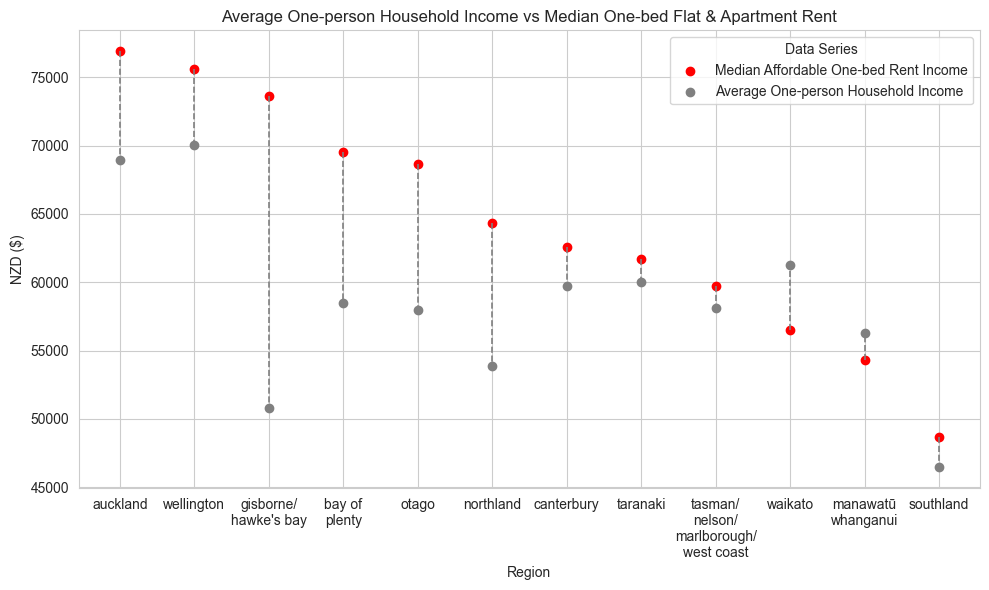

In [48]:
plot_rent_income(onep_flt_apt, 'median_annual_income', 'Average One-person Household Income', 'affordable_rent_wage_median', 'Median', 'Flat & Apartment')

In [49]:
rent.loc[(rent['dwell']=='Apartment') & (rent['nBedrms']=='1')]

,area,dwell,nBedrms,nLodged,nClosed,nCurr,mean,lq,med,uq,sd,brr,lmean,lsd,slq,suq
0,Auckland Region,Apartment,1,4614,4503,8592,478,400,460,550,130,5.00,6.1331,0.2800,382,557
27,Bay of Plenty Region,Apartment,1,105,90,243,451,368,450,520,95,3.62,6.0898,0.2139,382,510
46,Canterbury Region,Apartment,1,495,480,876,407,350,400,450,97,3.61,5.9830,0.2320,339,464
68,Gisborne Region,Apartment,1,21,24,27,464,375,475,525,92,3.82,6.1210,0.1945,399,519
83,Hawke's Bay Region,Apartment,1,54,39,117,424,368,445,485,96,4.22,6.0180,0.2786,340,496
99,Manawatu-Wanganui Region,Apartment,1,159,165,243,342,300,325,375,72,3.74,5.8161,0.1902,295,382
118,Marlborough Region,Apartment,1,9,15,24,303,200,300,340,101,3.09,5.6630,0.3297,231,360
148,Nelson Region,Apartment,1,66,60,96,415,388,410,450,61,3.60,6.0184,0.1480,372,454
164,Northland Region,Apartment,1,75,93,171,379,350,390,400,76,3.88,5.9175,0.2104,322,428
180,Otago Region,Apartment,1,459,405,780,437,350,430,500,184,3.48,6.0356,0.2756,347,503


In [50]:
rent.loc[(rent['dwell']=='Flat') & (rent['nBedrms']=='1')]

,area,dwell,nBedrms,nLodged,nClosed,nCurr,mean,lq,med,uq,sd,brr,lmean,lsd,slq,suq
10,Auckland Region,Flat,1,1269,1479,5079,431,380,425,475,102,3.63,6.0361,0.2672,349,501
33,Bay of Plenty Region,Flat,1,240,255,984,345,300,350,400,106,3.76,5.7761,0.4164,244,427
54,Canterbury Region,Flat,1,378,414,1557,324,290,320,350,84,3.65,5.7405,0.3017,254,381
71,Gisborne Region,Flat,1,27,36,132,397,323,410,500,111,3.80,5.9421,0.3064,310,468
88,Hawke's Bay Region,Flat,1,84,90,381,364,300,365,400,93,3.47,5.8611,0.2801,291,424
106,Manawatu-Wanganui Region,Flat,1,189,198,849,320,220,300,350,299,3.47,5.6606,0.3790,223,371
121,Marlborough Region,Flat,1,27,39,99,296,280,300,330,88,3.60,5.6224,0.4329,207,370
154,Nelson Region,Flat,1,66,75,222,367,331,355,394,64,3.57,5.8923,0.1675,324,406
169,Northland Region,Flat,1,138,138,588,320,250,350,380,97,3.60,5.7143,0.3406,241,381
188,Otago Region,Flat,1,258,261,741,377,296,360,458,115,3.47,5.8751,0.3655,278,456


In [51]:
#Bedsit/Flat: Part of a subdivided building, or a building which is independent of the primary residence of a property (eg, a sleep-out).

In [52]:
#Apartment: A property with self-contained areas (eg, apartments or units) and shared areas (eg, lifts or driveways).